In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# CNN


##  Flower Data

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

from utils.helper import fn_plot_tf_hist,fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------
inpDir = '../..\Classwork/input'
outDir = './output'
subDir = 'flower_photos'
modelDir = './models'
logDir = './logs'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 2 # number of cycles to run
PATIENCE = 50
LR_PATIENCE = 20
FACTOR_LR = 0.1
BATCH_SIZE = 32 # inline of Training Rows being 60000
IMG_HEIGHT = 190
IMG_WIDTH = 190


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
print (physical_devices)

[]


## Import data

In [6]:
'''
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

'''
data_dir = os.path.join(inpDir, subDir)
data_dir


'../..\\Classwork/input\\flower_photos'

In [7]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

## Creating datasets

In [8]:
# create training data
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)
# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [10]:
class_dict = {k:v for k,v in enumerate(class_names)}
class_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

## Visualize data in train_ds and test_ds

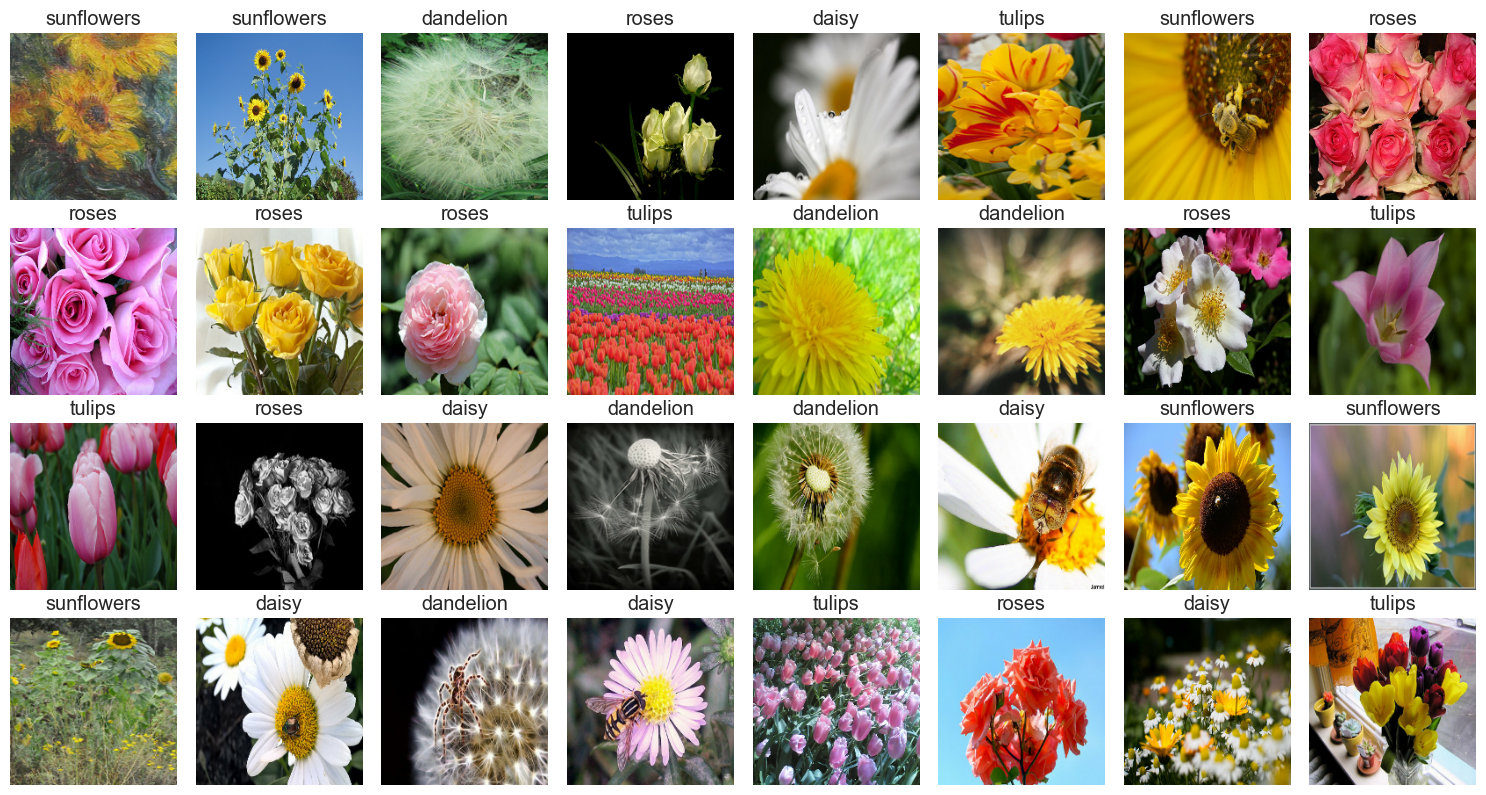

In [11]:
plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1):
    for i in range (BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE/8), 8, i +1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
plt.show()

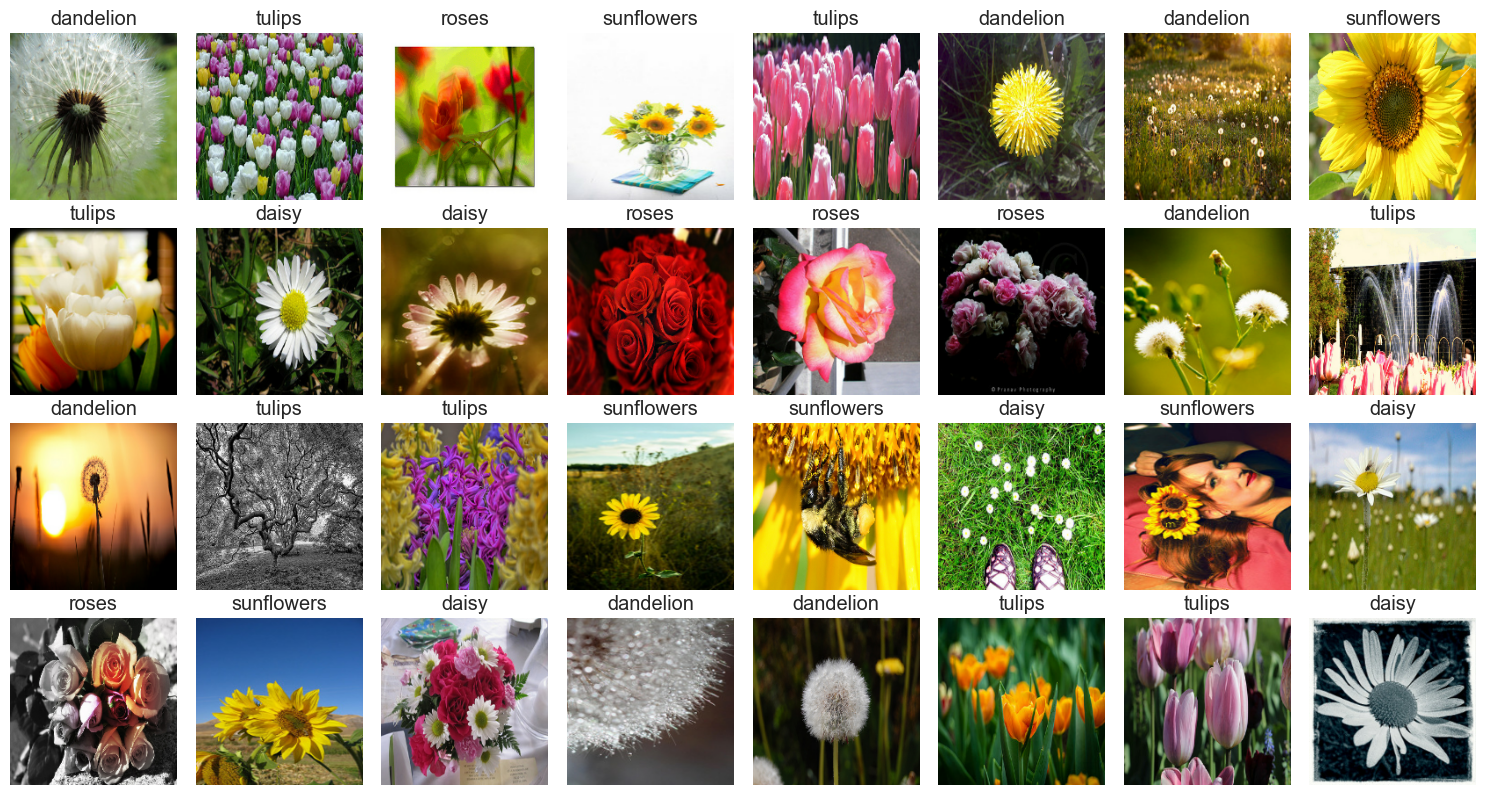

In [12]:
plt.figure(figsize=(15,8))

for images, labels in test_ds.take(1): # get me one batch

    for i in range (BATCH_SIZE): # loop over batch

        plt.subplot(int(BATCH_SIZE/8), 8, i +1) # access the axis

        plt.grid(False) # no to grid

        plt.imshow(images[i].numpy().astype('uint8')) # show image convert to numpy and int

        plt.title(class_names[labels[i]])

        plt.axis('off')

    plt.tight_layout()

plt.show()

## To check whether data is balanced or not

In [13]:
def fn_plot_label(tr_ds, ts_ds):

    plt.figure(figsize = (15,5)) # instantiate the figure

    plt.subplot(1,2,1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts

    plt.xticks(range(len(unique)), class_names)

    plt.title('Training Set')

    plt.subplot(1,2,2)

    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Test Set')


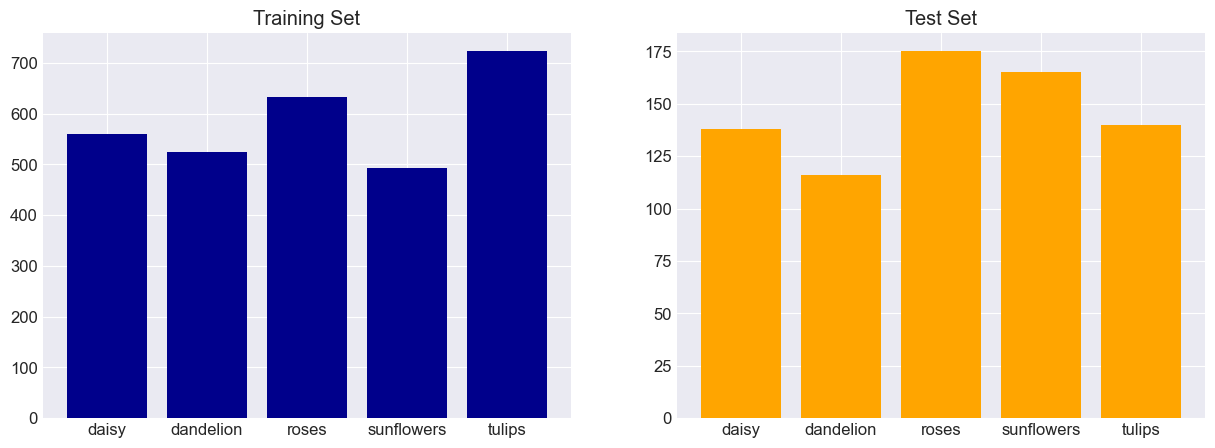

In [14]:
fn_plot_label(train_ds, test_ds)

## Model Building

from last conv layer to input layer

op size 2*2

1. conv layer f = 3, stride (s) =1  ip size = 4*4                        
2. maxpool layer f = 2,2, stride (s) =2  ip size = 8*8
3. conv layer f = 3, stride (s) =1  ip size = 10*10
4. maxpool layer f = 2,2, stride (s) =2  ip size = 20*20
5. conv layer f = 3, stride (s) =1  ip size = 22*22
6. maxpool layer f = 2,2, stride (s) =2  ip size = 44*44
7. conv layer f = 3, stride (s) =1  ip size = 46*46
8. maxpool layer f = 2,2, stride (s) =2  ip size = 92*92
9. conv layer f = 3, stride (s) =1  ip size = 94*94
10. maxpool layer f = 2,2, stride (s) =2  ip size = 188*188
11. conv layer f = 3, stride (s) =1  ip size = 190*190  (image size)

6 conv layers

In [15]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = len(class_names)
input_shape, num_classes

((190, 190, 3), 5)

In [16]:
def build_model (input_shape, num_classes):

  krnl_initializer = tf.keras.initializers.GlorotUniform()

  model = tf.keras.Sequential()

  ## preprocessing (scaling)
  model.add(tf.keras.layers.Rescaling(1./255.))

  ## 1 layer
  model.add(tf.keras.layers.Conv2D(32,(3,3),
                                   kernel_initializer = krnl_initializer,
                                   activation = 'relu',
                                   input_shape =input_shape)) ## output shape expected - 188*188*32

  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) ## 94*94*32

  ## 2 layer
  model.add(tf.keras.layers.Conv2D(64,3,
                                   kernel_initializer = krnl_initializer,
                                   activation = 'relu')) ## output shape expected - 92*92*64

  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) ## 46*46*64

  ## 3 layer
  model.add(tf.keras.layers.Conv2D(128,(3,3),
                                   kernel_initializer = krnl_initializer,
                                   activation = 'relu')) ## output shape expected - 44*44*128

  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) ## 22*22*128

  ## 4 layer
  model.add(tf.keras.layers.Conv2D(256,(3,3),
                                   kernel_initializer = krnl_initializer,
                                   activation = 'relu')) ## output shape expected - 20*20*256

  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) ## 10*10*256

  ## 5 layer
  model.add(tf.keras.layers.Conv2D(512,(3,3),
                                   kernel_initializer = krnl_initializer,
                                   activation = 'relu')) ## output shape expected - 8*8*512

  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) ## 4*4*512

  ## 6 layer
  model.add(tf.keras.layers.Conv2D(1024,(3,3),
                                   kernel_initializer = krnl_initializer,
                                   activation = 'relu')) ## output shape expected - 2*2*1024

  ## Head
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1024, activation = 'relu',kernel_initializer = krnl_initializer))
  model.add(tf.keras.layers.Dense(256, activation = 'relu',kernel_initializer = krnl_initializer))
  model.add(tf.keras.layers.Dense(64, activation = 'relu',kernel_initializer = krnl_initializer))
  model.add(tf.keras.layers.Dense(16, activation = 'relu',kernel_initializer = krnl_initializer))
  model.add(tf.keras.layers.Dense(num_classes))

  return model

In [17]:
model = build_model(input_shape, num_classes)
model

In [18]:
checkpoint_path = './weights_tf_flower'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=PATIENCE,
    verbose=2,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_delta=0.000001,
    cooldown=0,
    min_lr=0.0,
)

## Compile and train

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [20]:
history = model.fit(train_ds,
                    validation_data = test_ds ,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS, verbose=2,
                    callbacks=[model_checkpoint,es_callback,lr_callback])

Epoch 1/2


C:\Users\Administrator.DAI-PC2\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(





Epoch 1: val_loss improved from inf to 1.60601, saving model to .\weights_tf_flower
92/92 - 56s - loss: 1.6062 - accuracy: 0.2428 - val_loss: 1.6060 - val_accuracy: 0.2384 - lr: 0.0010 - 56s/epoch - 604ms/step
Epoch 2/2

Epoch 2: val_loss improved from 1.60601 to 1.60421, saving model to .\weights_tf_flower
92/92 - 50s - loss: 1.6046 - accuracy: 0.2463 - val_loss: 1.6042 - val_accuracy: 0.2384 - lr: 0.0010 - 50s/epoch - 546ms/step


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 190, 190, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 188, 188, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 94, 94, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       7

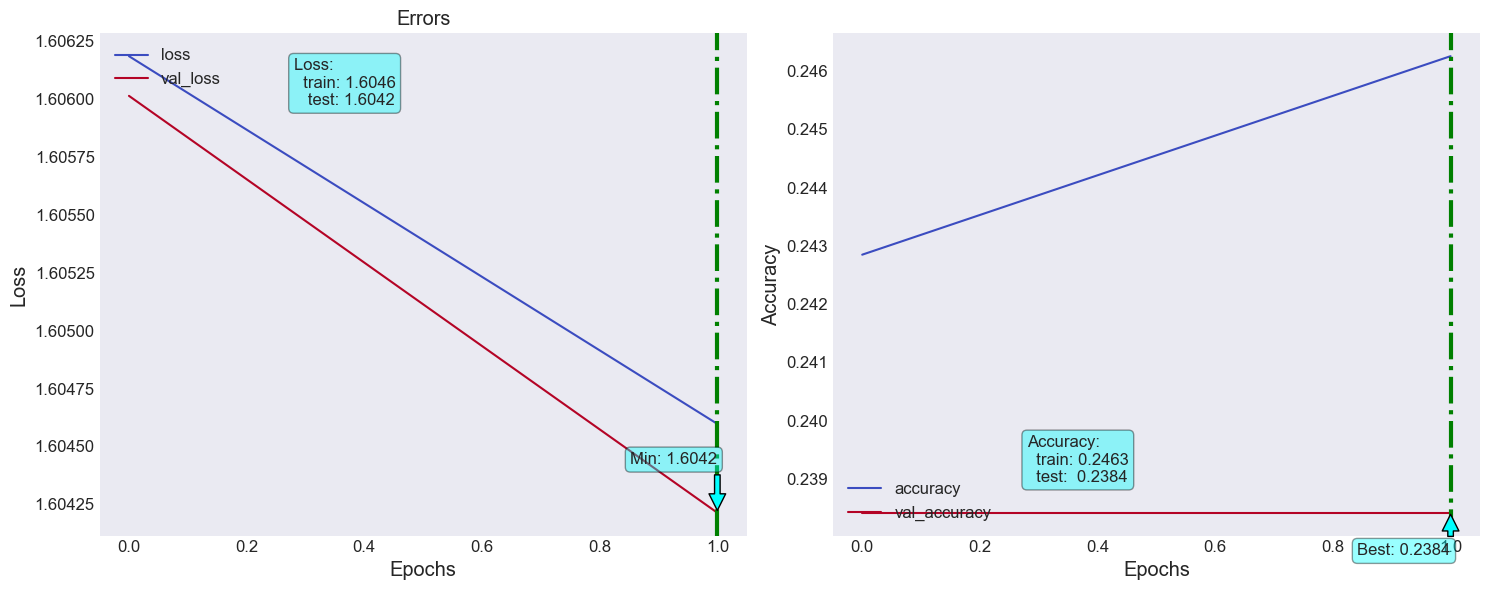

In [22]:
fn_plot_tf_hist(pd.DataFrame(history.history))

## Augmentation

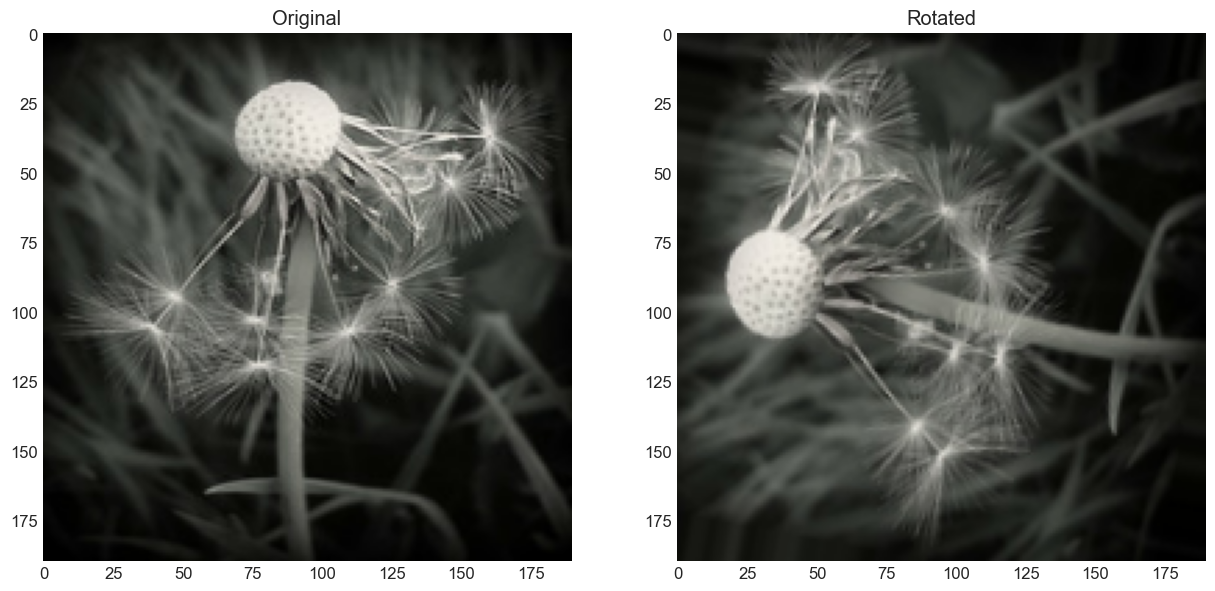

In [25]:
layer = tf.keras.layers.RandomRotation((-0.5,0.5), fill_mode = 'nearest', seed=RANDOM_STATE)

img_num= 0

plt.figure()

for images,labels in train_ds.take(1):
    
    out_img = layer(images)
    
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(images[img_num].numpy().astype('uint16'))
    plt.grid(False)

    plt.subplot(1,2,2)
    plt.title('Rotated')
    plt.imshow(out_img[img_num].numpy().astype('uint16'))
    plt.grid(False)